In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
#import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_pickle("./fr_sp_orders_from_tiers_51-56.pkl")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5204518 entries, 0 to 5271225
Data columns (total 26 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           float64
OSP_4_LEAD_P_PG_ID              int64
OSP_4_LEAD_P_PG_SHARE           float64
CZP_START_DATE                  datetime64[ns]
CZP_EXPIRY_DATE                 datetime64[ns]
CZP_ZTQ_ID                      int64
CZP_PERCENTAGE                  int64
CZP_PRICE  

In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,ORDER_DATETIME,WEEK_NUMBER,MONTH_NUMBER
0,407322334,95463604,2017-10-01,18:18,4,17565628,-3.7500,-3.1250,-3.1250,-3.1250,...,17798,1.0000,2017-08-18 01:08:00,2018-08-18 23:59:00,56,5,4.99,2017-10-01 18:18:00,39,10
1,407322335,95463604,2017-10-01,18:18,4,17565628,4.9900,4.1583,4.1583,4.1583,...,17798,1.0000,2017-08-18 01:08:00,2018-08-18 23:59:00,56,5,4.99,2017-10-01 18:18:00,39,10
2,407322333,95463604,2017-10-01,18:18,4,17565628,74.9900,18.8717,9.3897,62.4917,...,17798,1.0000,2017-08-18 01:08:00,2018-08-18 23:59:00,56,5,4.99,2017-10-01 18:18:00,39,10
3,407333343,95466306,2017-10-01,18:49,4,16471394,23.3267,7.7322,1.3954,19.4389,...,17871,0.3523,2017-03-25 19:59:00,2018-03-25 23:59:00,56,5,4.99,2017-10-01 18:49:00,39,10
4,407333343,95466306,2017-10-01,18:49,4,16471394,23.3267,7.7322,1.3954,19.4389,...,17871,0.3523,2017-03-25 19:59:00,2018-03-25 23:59:00,56,5,4.99,2017-10-01 18:49:00,39,10


In [5]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [6]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [7]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [8]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [9]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER',
       'FIRST_O_DATE', 'LAST_O_DATE', '1ST_O_COUNTER', 'D28', 'D56', 'D84',
       'D168', 'D252', 'D336'],
      dtype='object')

In [10]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': sum,
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [11]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [12]:
data['SCM_N_ORDER_NR'].nunique(), len(orders)

(1085176, 1085176)

In [13]:
orders.tail()

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,OSP_KO_COUNT_NET,CZP_START_DATE,...,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,D336
1085171,120154306,2018-09-30,18155963,56,61.85,21.1316,6.7418,51.5416,10,2017-11-26 21:08:00,...,2018-09-30 23:58:00,2017-11-26,2018-09-30,2,2017-12-24,2018-01-21,2018-02-18,2018-05-13,2018-08-05,2018-10-28
1085172,120154314,2018-09-30,18962659,53,89.25,12.0349,-4.7628,74.3749,8,2018-06-16 00:00:00,...,2018-09-30 23:58:00,2018-06-16,2018-09-30,4,2018-07-14,2018-08-11,2018-09-08,2018-12-01,2019-02-23,2019-05-18
1085173,120154326,2018-09-30,17076627,51,48.42,14.5300,4.9006,40.3500,19,2018-07-03 00:00:00,...,2018-09-30 23:59:00,2018-07-03,2018-09-30,13,2018-07-31,2018-08-28,2018-09-25,2018-12-18,2019-03-12,2019-06-04
1085174,120154327,2018-09-30,21219419,53,46.98,13.9701,2.3741,39.1500,5,2018-09-30 00:00:00,...,2018-09-30 23:59:00,2018-09-30,2018-09-30,5,2018-10-28,2018-11-25,2018-12-23,2019-03-17,2019-06-09,2019-09-01
1085175,120154341,2018-09-30,16638809,51,67.89,12.7350,3.9845,56.5750,18,2018-06-30 00:00:00,...,2018-09-30 23:59:00,2017-11-02,2018-09-30,9,2017-11-30,2017-12-28,2018-01-25,2018-04-19,2018-07-12,2018-10-04


In [14]:
orders['OK_28D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D28']) * 1
orders['OK_56D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D56']) * 1
orders['OK_84D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D84']) * 1
orders['OK_168D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D168']) * 1
orders['OK_252D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D252']) * 1
orders['OK_336D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D336']) * 1

In [15]:
orders['COUNTER_28D'] = orders['OK_28D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_56D'] = orders['OK_56D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_84D'] = orders['OK_84D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_168D'] = orders['OK_168D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_252D'] = orders['OK_252D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_336D'] = orders['OK_336D'] * orders['OSP_KO_COUNT_NET']

In [16]:
orders['MAX_COUNTER_28D'] = orders['COUNTER_28D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_56D'] = orders['COUNTER_56D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_84D'] = orders['COUNTER_84D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_168D'] = orders['COUNTER_168D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_252D'] = orders['COUNTER_252D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_336D'] = orders['COUNTER_336D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')

In [17]:
orders['RR_28D'] = (orders['MAX_COUNTER_28D'] > orders['1ST_O_COUNTER']) * 1
orders['RR_56D'] = (orders['MAX_COUNTER_56D'] > orders['MAX_COUNTER_28D']) * 1
orders['RR_84D'] = (orders['MAX_COUNTER_84D'] > orders['MAX_COUNTER_56D']) * 1 
orders['RR_168D'] = (orders['MAX_COUNTER_168D'] > orders['MAX_COUNTER_84D']) * 1
orders['RR_252D'] = (orders['MAX_COUNTER_252D'] > orders['MAX_COUNTER_168D']) * 1 
orders['RR_336D'] = (orders['MAX_COUNTER_336D'] > orders['MAX_COUNTER_168D']) * 1

In [18]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'OK_28D',
       'OK_56D', 'OK_84D', 'OK_168D', 'OK_252D', 'OK_336D', 'COUNTER_28D',
       'COUNTER_56D', 'COUNTER_84D', 'COUNTER_168D', 'COUNTER_252D',
       'COUNTER_336D', 'MAX_COUNTER_28D', 'MAX_COUNTER_56D', 'MAX_COUNTER_84D',
       'MAX_COUNTER_168D', 'MAX_COUNTER_252D', 'MAX_COUNTER_336D', 'RR_28D',
       'RR_56D', 'RR_84D', 'RR_168D', 'RR_252D', 'RR_336D'],
      dtype='object')

In [19]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'CZP_START_DATE': 'unique',
              'CZP_EXPIRY_DATE': 'unique',
              'FIRST_O_DATE': min,
              'LAST_O_DATE': min,
              '1ST_O_COUNTER': min,
              'COUNTER_28D': max,
              'COUNTER_56D': max,
              'COUNTER_84D': max,
              'COUNTER_168D': max,
              'COUNTER_252D': max,
              'COUNTER_336D': max
              }

In [20]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [21]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [22]:
customers.head()

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_<lambda>,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_<lambda>,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_<lambda>,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,CZP_EXPIRY_DATE_unique,FIRST_O_DATE_min,LAST_O_DATE_min,1ST_O_COUNTER_min,COUNTER_28D_max,COUNTER_56D_max,COUNTER_84D_max,COUNTER_168D_max,COUNTER_252D_max,COUNTER_336D_max
0,90143,[52],6,569.11,"[77.56, 155.12, 132.83, 81.44, 61.08, 61.08]",129.54,"[17.03, 32.91, 29.73, 20.35, 14.86, 14.66]",76.31,"[9.18, 25.26, 14.95, 11.84, 7.06, 8.02]",474.26,...,[2020-01-02T23:59:00.000000000],2017-10-11,2018-09-19,24,24,24,25,26,27,28
1,240667,[54],10,2239.16,"[289.47, 68.84, 443.73, 439.02, 97.9, 68.79, 1...",454.45,"[37.57, 14.55, 59.7, 53.96, 37.39, 13.74, 41.6...",218.89,"[21.25, 6.7, 28.57, 18.44, 9.21, 1.16, 31.94, ...",1867.96,...,"[2017-11-02T23:02:00.000000000, 2020-12-08T23:...",2017-10-05,2018-09-12,168,170,170,170,175,178,190
2,270025,[52],4,379.25,"[129.94, 109.57, 107.64, 32.1]",45.40,"[18.28, 8.52, 9.78, 8.82]",18.50,"[11.15, 1.07, 2.58, 3.7]",316.04,...,[2020-04-08T23:59:00.000000000],2017-10-15,2018-05-02,86,86,86,86,89,90,90
3,281298,[56],7,447.86,"[49.37, 24.87, 42.72, 82.62, 97.34, 102.54, 48.4]",112.78,"[17.26, 10.22, 10.09, 3.12, 27.68, 28.39, 16.02]",40.76,"[9.21, 4.21, 2.48, -8.76, 10.94, 15.56, 7.13]",373.22,...,[2019-04-18T00:00:00.000000000],2018-04-18,2018-09-10,207,208,210,211,213,213,213
4,289618,[51],1,85.32,[85.32],31.96,[31.96],22.25,[22.25],71.10,...,[2019-07-24T00:00:00.000000000],2018-07-24,2018-07-24,36,36,36,36,36,36,36


In [23]:
customers['DIFF_DAYS'] = (customers['LAST_O_DATE_min'] - customers['FIRST_O_DATE_min']).dt.days

In [24]:
customers['SUIT_28D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=28)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_56D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=56)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_84D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=84)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_168D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=168)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_252D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=252)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_336D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=336)) >= customers['FIRST_O_DATE_min']) * 1

In [25]:
customers['R28D'] = (customers['COUNTER_28D_max'] > customers['1ST_O_COUNTER_min']) * 1
customers['R56D'] = (customers['COUNTER_56D_max'] > customers['COUNTER_28D_max']) * 1
customers['R84D'] = (customers['COUNTER_84D_max'] > customers['COUNTER_56D_max']) * 1
customers['R168D'] = (customers['COUNTER_168D_max'] > customers['COUNTER_84D_max']) * 1
customers['R252D'] = (customers['COUNTER_252D_max'] > customers['COUNTER_168D_max']) * 1
customers['R336D'] = (customers['COUNTER_336D_max'] > customers['COUNTER_252D_max']) * 1

In [26]:
customers['RR_28D'] = customers['R28D']
customers['RR_56D'] = customers['R56D'] | customers['RR_28D']
customers['RR_84D'] = customers['R84D'] | customers['RR_56D']
customers['RR_168D'] = customers['R168D'] | customers['RR_84D']
customers['RR_252D'] = customers['R252D'] | customers['RR_168D']
customers['RR_336D'] = customers['R336D'] | customers['RR_252D']

In [27]:
customers['R_28D'] = customers['RR_28D'] * customers['SUIT_28D']
customers['R_56D'] = customers['RR_56D'] * customers['SUIT_56D']
customers['R_84D'] = customers['RR_84D'] * customers['SUIT_84D']
customers['R_168D'] = customers['RR_168D']  * customers['SUIT_168D']
customers['R_252D'] = customers['RR_252D'] * customers['SUIT_252D']
customers['R_336D'] = customers['RR_336D'] * customers['SUIT_336D']

In [28]:
customers.to_pickle("./test_local_fr_sp_customers_tiers_51-56.pkl")

In [29]:
mask = [len(i) == 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [30]:
sp_customers = customers[mask]

In [31]:
def get_number_from_string(i):
    changes = str(i).replace('[', '').replace(']', '')
    return int(changes)

In [32]:
t_customers = sp_customers.copy()

In [33]:
t_customers['CZP_ZTQ_ID_unique'] = t_customers['CZP_ZTQ_ID_unique'].map(get_number_from_string)

In [34]:
t_customers['CZP_ZTQ_ID_unique'].value_counts()

51    56217
56    43251
52    40288
53    29562
54    24555
55     5759
Name: CZP_ZTQ_ID_unique, dtype: int64

In [35]:
tier_rr_28d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_28D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_28D'].sum() * 100).round(2)
tier_rr_56d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_56D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_56D'].sum() * 100).round(2)
tier_rr_84d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_84D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_84D'].sum() * 100).round(2)
tier_rr_168d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_168D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_168D'].sum() * 100).round(2)
tier_rr_252d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_252D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_252D'].sum() * 100).round(2)
tier_rr_336d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_336D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_336D'].sum() * 100).round(2)

In [36]:
rep_rate_tiers = pd.DataFrame([tier_rr_28d, tier_rr_56d, tier_rr_84d, tier_rr_168d, tier_rr_252d, tier_rr_336d]).T
rep_rate_tiers.columns = ['28d', '56d', '84d', '168d', '252d', '336d']
rep_rate_tiers

,28d,56d,84d,168d,252d,336d
CZP_ZTQ_ID_unique,,,,,,
51,20.40,48.85,66.51,83.47,88.11,92.17
52,20.73,46.74,64.92,86.45,92.92,96.33
53,21.58,48.61,65.85,82.79,87.75,91.96
54,21.44,46.63,64.91,86.25,92.66,95.99
55,16.06,38.71,53.19,67.65,70.32,73.15
56,18.39,43.96,59.55,74.82,77.78,80.59


In [37]:
ztq = [51, 52, 53, 54, 55, 56]

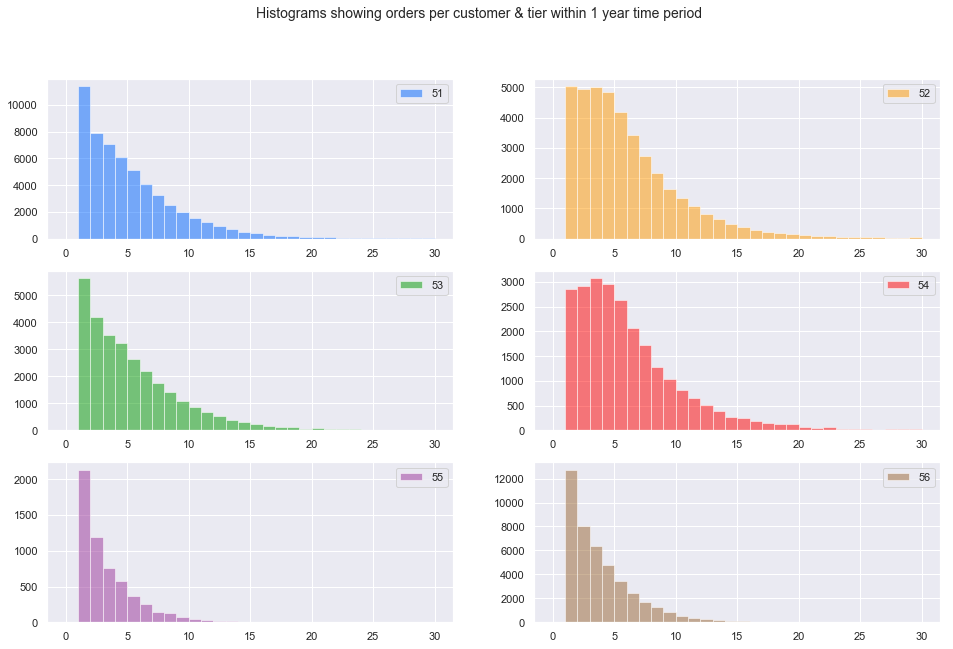

,Tier 51 ORDERS,Tier 52 ORDERS,Tier 53 ORDERS,Tier 54 ORDERS,Tier 55 ORDERS,Tier 56 ORDERS
count,56217.00,40288.00,29562.00,24555.00,5759.00,43251.00
mean,4.92,5.77,5.14,5.91,2.94,3.47
std,4.32,5.58,4.65,5.13,2.52,3.50
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,3.00,2.00,3.00,1.00,1.00
50%,4.00,5.00,4.00,5.00,2.00,3.00
75%,7.00,8.00,7.00,8.00,4.00,5.00
max,79.00,558.00,110.00,136.00,24.00,434.00


In [38]:
sns.set()
plt.figure(figsize=(16,10))
plt.suptitle('Histograms showing orders per customer & tier within 1 year time period', fontsize=14)
plt.subplot(321)
data_tier_51 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 51]
data_tier_51['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#0066ff', alpha=0.5)
plt.legend([51])
plt.subplot(322)
data_tier_52 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 52]
data_tier_52['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff9900', alpha=0.5)
plt.legend([52])
plt.subplot(323)
data_tier_53 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 53]
data_tier_53['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#009900', alpha=0.5)
plt.legend([53])
plt.subplot(324)
data_tier_54 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 54]
data_tier_54['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff0000', alpha=0.5)
plt.legend([54])
plt.subplot(325)
data_tier_55 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 55]
data_tier_55['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#993399', alpha=0.5)
plt.legend([55])
plt.subplot(326)
data_tier_56 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 56]
data_tier_56['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#996633', alpha=0.5)
plt.legend([56])
plt.show() 

concat_df = pd.DataFrame()
for tq in ztq:
    data_tier = t_customers[t_customers['CZP_ZTQ_ID_unique'] == tq]
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_tier['SCM_N_ORDER_NR_len'].describe().round(2)),
                           ], axis=1)
concat_df.columns = ['Tier 51 ORDERS', 'Tier 52 ORDERS', 'Tier 53 ORDERS',
                     'Tier 54 ORDERS', 'Tier 55 ORDERS', 'Tier 56 ORDERS']
display(concat_df)

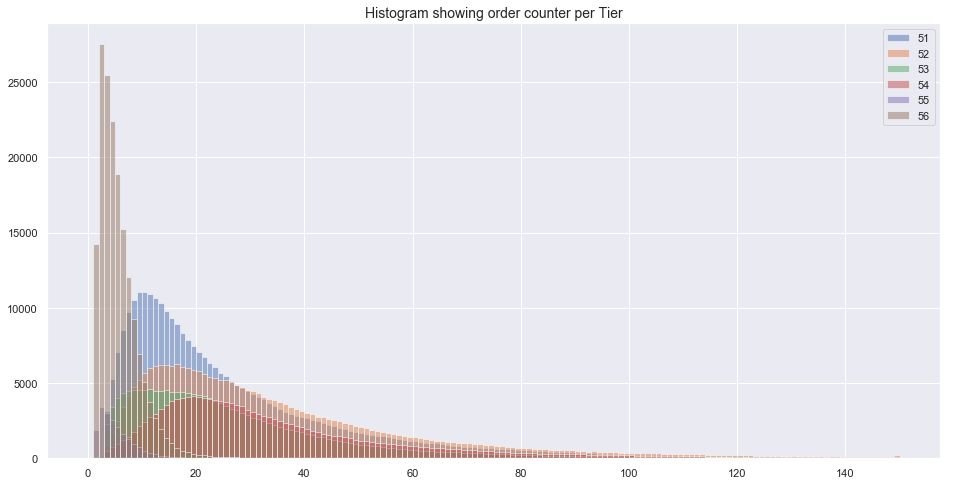

,Tier 51 Order_Counter,Tier 52 Order_Counter,Tier 53 Order_Counter,Tier 54 Order_Counter,Tier 55 Order_Counter,Tier 56 Order_Counter
count,310864.00,261502.00,164219.00,157635.00,19317.00,171639.00
mean,29.71,41.98,29.08,40.99,5.01,5.90
std,30.37,79.03,30.28,63.45,4.55,14.72
min,1.00,2.00,1.00,1.00,1.00,1.00
25%,12.00,17.00,12.00,18.00,2.00,3.00
50%,20.00,29.00,22.00,29.00,4.00,4.00
75%,37.00,48.00,36.00,46.00,6.00,7.00
max,491.00,1828.00,738.00,2062.00,118.00,1614.00


In [39]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order counter per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_counter_values = [i for i in data_tier['OSP_KO_COUNT_NET'].values]
    plt.hist(order_counter_values, bins=150, range=(0, 150), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_counter_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Counter', 'Tier 52 Order_Counter', 'Tier 53 Order_Counter',
                     'Tier 54 Order_Counter', 'Tier 55 Order_Counter', 'Tier 56 Order_Counter']
display(concat_df)

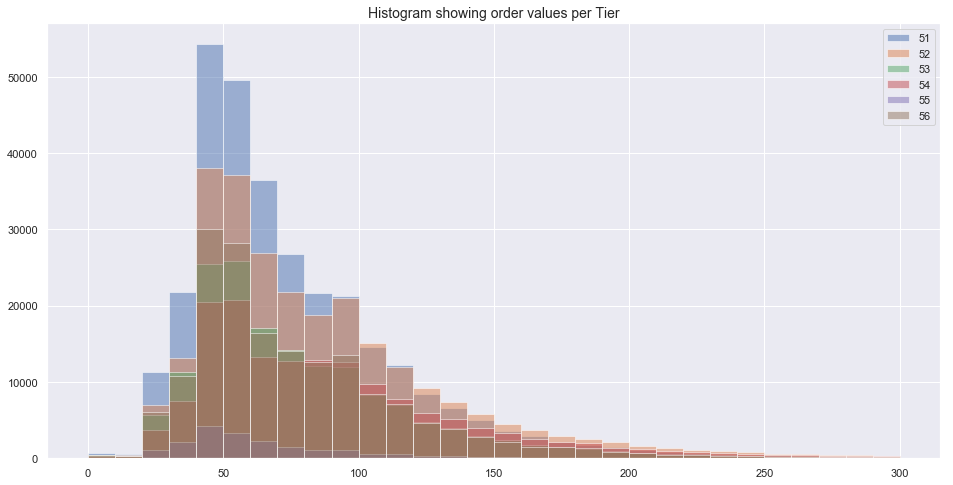

,Tier 51 Order_Values,Tier 52 Order_Values,Tier 53 Order_Values,Tier 54 Order_Values,Tier 55 Order_Values,Tier 56 Order_Values
count,310864.00,261502.00,164219.00,157635.00,19317.00,171639.00
mean,76.32,87.08,80.41,93.53,66.29,78.26
std,44.35,54.90,50.91,66.45,39.40,47.84
min,-41.05,-68.24,-50.69,-50.31,-19.59,-35.58
25%,48.47,51.38,48.50,52.24,44.05,47.89
50%,63.99,72.74,66.49,78.84,55.79,65.51
75%,94.04,106.68,98.25,113.54,78.02,94.99
max,1058.01,1962.27,1487.13,3546.67,999.08,1847.05


In [40]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order values per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values = [i for i in data_tier['SCM_SALES_BMF'].values]
    plt.hist(order_values, bins=30, range=(0, 300), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Values', 'Tier 52 Order_Values', 'Tier 53 Order_Values',
                     'Tier 54 Order_Values', 'Tier 55 Order_Values', 'Tier 56 Order_Values']
display(concat_df)

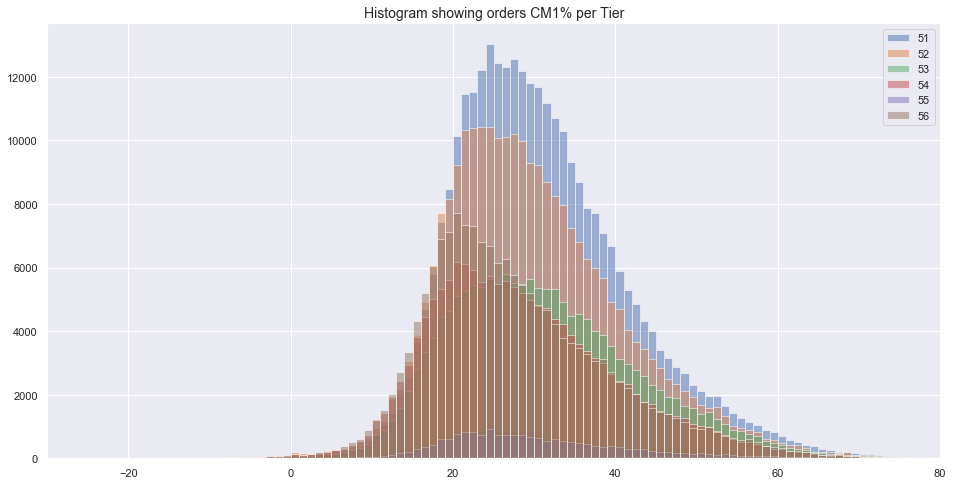

,Tier 51 Order_CM1%,Tier 52 Order_CM1%,Tier 53 Order_CM1%,Tier 54 Order_CM1%,Tier 55 Order_CM1%,Tier 56 Order_CM1%
count,310847.00,261485.00,164196.00,157621.00,19315.00,171626.00
25%,23.34,22.20,22.56,20.26,22.18,19.79
50%,29.58,28.59,29.92,27.08,28.45,25.91
75%,37.38,36.62,38.56,35.65,37.05,34.61


In [41]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM1% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm1 = [i for i in data_tier['SCM_D_FINANCE_CM1'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm1 = [i/j * 100 for i, j in list(zip(order_values_cm1, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm1, bins=100, range=(-25, 75), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm1).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM1%', 'Tier 52 Order_CM1%', 'Tier 53 Order_CM1%',
                     'Tier 54 Order_CM1%', 'Tier 55 Order_CM1%', 'Tier 56 Order_CM1%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

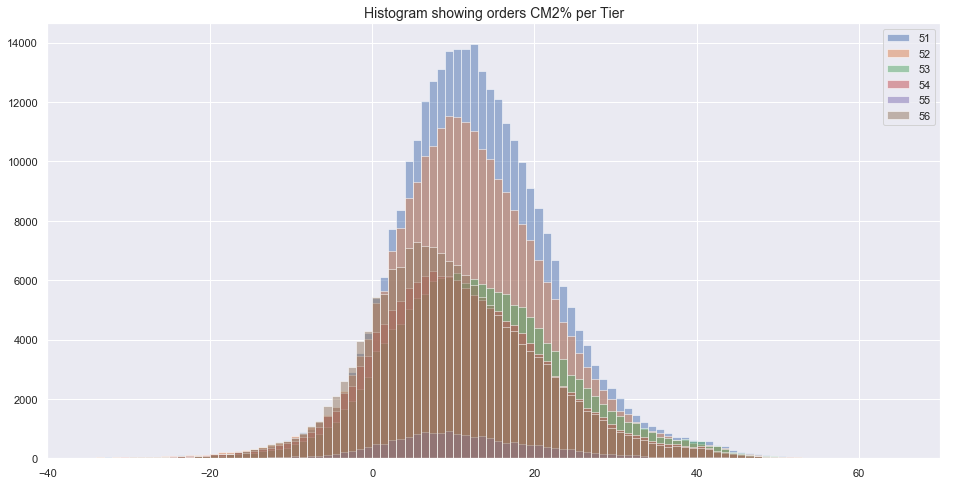

,Tier 51 Order_CM2%,Tier 52 Order_CM2%,Tier 53 Order_CM2%,Tier 54 Order_CM2%,Tier 55 Order_CM2%,Tier 56 Order_CM2%
count,310847.00,261485.00,164196.00,157621.00,19315.00,171626.00
25%,6.42,5.72,5.60,3.82,4.82,2.97
50%,12.26,11.70,12.50,10.33,10.42,9.10
75%,18.77,18.47,20.06,17.94,17.61,16.67


In [42]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM2% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm2 = [i for i in data_tier['SCM_D_FINANCE_CM2'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm2 = [i/j * 100 for i, j in list(zip(order_values_cm2, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm2, bins=100, range=(-35, 65), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm2).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM2%', 'Tier 52 Order_CM2%', 'Tier 53 Order_CM2%',
                     'Tier 54 Order_CM2%', 'Tier 55 Order_CM2%', 'Tier 56 Order_CM2%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

In [43]:
metrics_ztq = pd.DataFrame(columns=['ZTQ','active_customers', 'orders', 'sales_bmf', 'net_sales', 'CM1', 'CM2', 'CM1%', 'CM2%',
                                   'discount_amount', 'orders_%_neg_cm1', 'loss_in_CM1', 'orders_%_neg_cm2', 'loss_in_CM2'])
for tq in ztq:
    df_elems = []
    data_tier = data[data['CZP_ZTQ_ID'] == tq]
    df_elems.append(tq)
    df_elems.append(data_tier['CUS_N_KEY_CUSTOMER'].nunique())
    df_elems.append(data_tier['SCM_N_ORDER_NR'].nunique())
    df_elems.append(data_tier['SCM_SALES_BMF'].sum())
    df_elems.append(data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append((data_tier[data_tier['SCM_MASTER_AP_ID'] == 42715]['SCM_SALES_BMF']).sum())
    
    cm1_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()
    orders_neg_cm1 = cm1_per_order[cm1_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm1)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm1_per_order[cm1_per_order < 0].sum())
    
    cm2_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()
    orders_neg_cm2 = cm2_per_order[cm2_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm2)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm2_per_order[cm2_per_order < 0].sum())
    
    new_row = pd.DataFrame.from_records([df_elems], columns=metrics_ztq.columns)
    metrics_ztq = metrics_ztq.append(new_row, ignore_index=True)
    
display(metrics_ztq.round(2))

,ZTQ,active_customers,orders,sales_bmf,net_sales,CM1,CM2,CM1%,CM2%,discount_amount,orders_%_neg_cm1,loss_in_CM1,orders_%_neg_cm2,loss_in_CM2
0,51,65702,310864,23725224.45,19785157.16,5861591.44,2668975.74,29.63,13.49,-741019.12,0.61,-5964.33,8.27,-65876.61
1,52,47675,261502,22772852.15,18996357.80,5468167.92,2474602.44,28.79,13.03,-748186.71,0.73,-6745.71,9.79,-74622.23
2,53,32838,164219,13205527.68,11026590.47,3297337.58,1541832.04,29.90,13.98,-699985.86,0.79,-5209.78,10.58,-47626.18
3,54,27413,157635,14743715.87,12310956.22,3370485.84,1471674.83,27.38,11.95,-815401.19,0.96,-7396.39,14.10,-70169.71
4,55,6487,19317,1280582.74,1069001.09,308798.32,129377.17,28.89,12.10,-39448.20,0.67,-353.19,10.90,-4565.46
5,56,49574,171639,13432884.83,11207322.54,2984772.13,1222084.65,26.63,10.90,-705376.76,0.91,-5835.85,15.63,-71391.93
